In [12]:
import os
import fdsreader
import matplotlib

import numpy as np
import pandas as pd
import Processing as proc
import matplotlib.pyplot as plt

from importlib import reload


# Reload Python modules for changes that occurred during runtime.
reload(proc);

# McCaffrey Plumes

## Setup Description

The simulations are based on the different setups of the [McCaffrey plume experiments](https://nvlpubs.nist.gov/nistpubs/Legacy/IR/nbsir79-1910.pdf), which are proposed and discussed in the [Extra Task: Simulation of a purely buoyant diffusion flame](extra-task). The goal is to reproduce aspects of McCaffreys work, like determining the temperature and velocity changes on the plume centre axis over the height. 

In this example, the directory for our project is called `FirePlumes`. Inside the project directory, three other directories are created: one to store the jupyter notebooks `RunReports`, one for the simulations `McCaffrey`, and one for general information `GeneralInformation`. 

The `McCaffrey` directory contains different simulations of the McCaffrey setup. In `GeneralInformation` files containing the extracted experiment data are located. These data series were extracted using the [WebPlotDigitizer](../01_basic/04_basic_example_iv). The Jupyter notebooks are to be located in `RunReports`.

As structure it is recommended that the user creates directories labeled based on the experiment setup, for example `14kW`. This way data can nicely be accessed when following this example here. Furthermore, simulations are performed with differernt resolutions, based on the reference cell. Simulations of these groups are referred to by the resolutin with respect to the reference cell and are stored in according directories. For example the "C5" directory contains simulations for which the reference cell was divided by 5 in each direction.



````{admonition} Precomputed simulation data McCaffrey 14 kW
:class: tip
[Download link](https://uni-wuppertal.sciebo.de/s/p8nn60Kmtd3qoRt/download?path=%2F&files=fire_plumes_mccaffrey_14kw.zip)
````

````{admonition} Precomputed simulation data McCaffrey 22 kW
:class: tip
[Download link](https://uni-wuppertal.sciebo.de/s/p8nn60Kmtd3qoRt/download?path=%2F&files=fire_plumes_mccaffrey_22kw.zip)
````

````{admonition} Precomputed simulation data McCaffrey 33 kW
:class: tip
[Download link](https://uni-wuppertal.sciebo.de/s/p8nn60Kmtd3qoRt/download?path=%2F&files=fire_plumes_mccaffrey_33kw.zip)
````

````{admonition} Precomputed simulation data McCaffrey 45 kW
:class: tip
[Download link](https://uni-wuppertal.sciebo.de/s/p8nn60Kmtd3qoRt/download?path=%2F&files=fire_plumes_mccaffrey_45kw.zip)
````

````{admonition} Precomputed simulation data McCaffrey 57 kW
:class: tip
[Download link](https://uni-wuppertal.sciebo.de/s/p8nn60Kmtd3qoRt/download?path=%2F&files=fire_plumes_mccaffrey_57kw.zip)
````

````{admonition} McCaffrey Experiment Data
:class: tip
[Download link](https://uni-wuppertal.sciebo.de/s/p8nn60Kmtd3qoRt/download?path=%2F&files=fire_plumes_mccaffrey_experimental_data.zip)
````

## Some Basic Setup

Sometimes it is helpful to keep track of the versions of the used packages. This can be accomplished with the following input.

In [13]:
print('Package Versions')
print('---------------------')
print('Pandas version: {}'.format(pd.__version__))
print('Numpy version: {}'.format(np.__version__))
print('Matplotlib version: {}'.format(matplotlib.__version__))
print('fdsreader version: {}'.format(fdsreader.__version__))

Package Versions
---------------------
Pandas version: 1.5.0
Numpy version: 1.23.3
Matplotlib version: 3.6.0
fdsreader version: 1.8.4


It is also helpful to have the current working directory stored in a variable for easy access.

In [14]:
# Get current working directory.
cwd = os.getcwd()
cwd

'/media/tristan/Extra Drive 1/git/LectureFireSimulation/book/content/examples/03_advanced'

In the following code block general information necessary for this notebook is stored. For example, path to different directories that contain static information, such as directories containing experiment data or path fragments to different sub-sets of simulations. 

Furthermore, functionality is provided that creates an output directory, if it does not exist. The path to this output directory is stored in a variable for easy access during this norebook. When keeping the same strategy across similar notebooks for different projects, one only needs to adjust the directory lable in this cell and can always call the respective variable. 

In [23]:
# General information used in this notebook.

# Define base path to McCaffrey simulations.
# add ".." as first element in os.path.join()
mcc_sim_base_path = os.path.join("McCaffreyPlumes")


# Path to experiment data.
# add ".." as first element in os.path.join()
exp_base_path = os.path.join("GeneralInformation", "ExperimentData")


# Initialise data collection.
plume_sims = dict()
plume_sims["McCaffrey"] = dict()
plume_sims["McCaffrey"]["Exp"] = {
    "14kW": {
        "Burner": 14.4, 
        "Marker": 'o'},
    "22kW": {
        "Burner": 21.7,
        "Marker": 'h'},
    "33kW": {
        "Burner": 33.0,
        "Marker": '^'},
    "45kW": {
        "Burner": 44.9,
        "Marker": 's'},
    "57kW": {
        "Burner": 57.5,
        "Marker": 'D'}
}


# # Directory used to collect the output produced by this notebook.
# output_dir = "OutputMcCaffrey"
# if not os.path.isdir(output_dir):
#     os.mkdir(output_dir)
#     print("* Output directory created.")
# else:
#     print("* Output directory already exists.")

* Output directory already exists.


In [16]:
# Check dictionary for data collection.
plume_sims["McCaffrey"]["Exp"]

{'14kW': {'Burner': 14.4, 'Marker': 'o'},
 '22kW': {'Burner': 21.7, 'Marker': 'h'},
 '33kW': {'Burner': 33.0, 'Marker': '^'},
 '45kW': {'Burner': 44.9, 'Marker': 's'},
 '57kW': {'Burner': 57.5, 'Marker': 'D'}}

## Read Experiment Data

In the following block the experiment data is read. These data sets are also stored in the same dictionary with all the data series from the simulations. This keeps everthing nicely organised.

In [17]:
# Read temperature expertiment data.

# Temperature file name base.
mcc_temp_label = "McCaffrey_Temperature_{}.csv"


# Shortend for convenience.
mcc_exp = plume_sims["McCaffrey"]["Exp"]

# Go over all experiment setups.
for exp_label in list(mcc_exp):
    #print(exp_label)
    # Build file label from dictionary keys.
    file_label = mcc_temp_label.format(exp_label)
    # Build file path to experiment data.
    exp_path = os.path.join(exp_base_path, file_label)
    
    # Read file as Pandas DataFrame.
    exp_df = pd.read_csv(exp_path, header=1)
    
    # Collect DataFrame.
    mcc_exp[exp_label]["Temperature"] = exp_df
    
    
# Check result.
plume_sims["McCaffrey"]["Exp"]["14kW"]["Temperature"].head()

Height  Temperature
0  0.015375   749.297459
1  0.017051   756.967266
2  0.020437   787.727232
3  0.023999   809.319913
4  0.027351   820.929903

In [18]:
# Read velocity expertiment data.

# Temperature file name base.
mcc_temp_label = "McCaffrey_Velocity_{}.csv"


# Shortend for convenience.
mcc_exp = plume_sims["McCaffrey"]["Exp"]

# Go over all experiment setups.
for exp_label in list(mcc_exp):
    #print(exp_label)
    # Build file label from dictionary keys.
    file_label = mcc_temp_label.format(exp_label)
    # Build file path to experiment data.
    exp_path = os.path.join(exp_base_path, file_label)
    
    # Read file as Pandas DataFrame.
    exp_df = pd.read_csv(exp_path, header=1)
    
    # Collect DataFrame.
    mcc_exp[exp_label]["Velocity"] = exp_df
    
    
# Check result.
plume_sims["McCaffrey"]["Exp"]["14kW"]["Velocity"].head()

Height  Velocity
0  0.015426  0.748036
1  0.017185  0.839401
2  0.020562  0.936540
3  0.023999  1.052238
4  0.027461  1.145382

In [19]:
# Read idealised data.

# Idealised data file names.
mcc_tempideal_label = "McCaffrey_Temperature_Idealised.csv"
mcc_veloideal_label = "McCaffrey_Velocity_Idealised.csv"


# Shortend for convenience.
plume_sims["McCaffrey"]["Ideal"] = dict()
mcc_ideal = plume_sims["McCaffrey"]["Ideal"]

# Build file path to experiment data.
exp_path = os.path.join(exp_base_path, mcc_tempideal_label)
# Read file as Pandas DataFrame.
exp_df = pd.read_csv(exp_path, header=1)
# Collect DataFrame.
mcc_ideal["Temperature"] = exp_df

# Build file path to experiment data.
exp_path = os.path.join(exp_base_path, mcc_veloideal_label)
# Read file as Pandas DataFrame.
exp_df = pd.read_csv(exp_path, header=1)
# Collect DataFrame.
mcc_ideal["Velocity"] = exp_df
    
    
# Check result.
plume_sims["McCaffrey"]["Ideal"]["Velocity"].head()

Height  Velocity
0   0.008       0.6
1   0.080       1.9
2   0.200       1.9
3   0.600       1.3

## Plot Experiment Data

After the experiment data was read, now we create plots to get an overview on it.

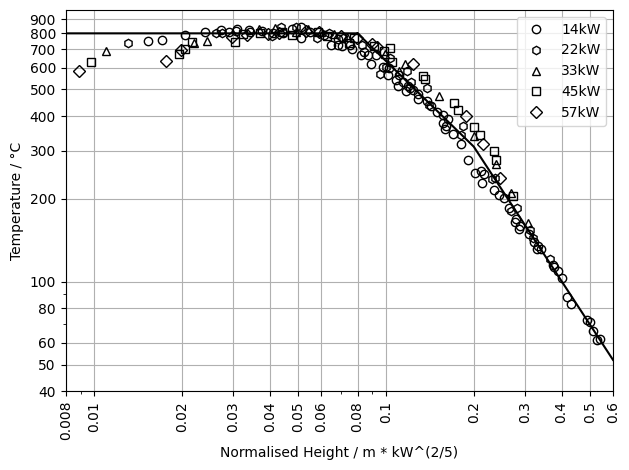

In [20]:
# Plot the temperature experiment data.

# Define ticks and tick labels.
x_ticks = [0.008, 0.01, 0.02,0.03,0.04,0.05,0.06,0.08,0.1,0.2,0.3,0.4,0.5,0.6]
x_ticklabels = ["0.008", "0.01", "0.02","0.03","0.04","0.05","0.06","0.08","0.1","0.2","0.3","0.4","0.5","0.6"]
y_ticks = [40,50,60,80,100,200,300,400,500,600,700,800,900]
y_ticklabels = ["40","50","60","80","100","200","300","400","500","600","700","800","900"]


# Set up plotting.
fig, ax = plt.subplots()

# Shortend for convenience.
mcc_exp = plume_sims["McCaffrey"]["Exp"]
mcc_ideal = plume_sims["McCaffrey"]["Ideal"]
# Go over all experiment setups.
for exp_label in list(mcc_exp):
    
    height = mcc_exp[exp_label]["Temperature"]["Height"]
    temp = mcc_exp[exp_label]["Temperature"]["Temperature"]
    plot_marker = mcc_exp[exp_label]["Marker"]
    
    plt.plot(height,
             temp,
             linestyle='None', marker=plot_marker,
             fillstyle='none', color='k',
             label=exp_label)
    
    
plt.plot(mcc_ideal["Temperature"]["Height"], 
         mcc_ideal["Temperature"]["Temperature"], 
         color='k')


# Plot meta data.
plt.grid()
plt.xlim(0.008, 0.6)
plt.xscale('log')
plt.yscale('log')

plt.xlabel("Normalised Height / m * kW^(2/5)")
plt.ylabel("Temperature / °C")

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticklabels, rotation = 90, 
                   ha="center")

ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticklabels, ha="right")

plt.legend()
plt.tight_layout()


# # Save image.
# file_label = f"McCaffrey_Experiment_Temp.png"
# plot_path = os.path.join(output_dir, 
#                          file_label)
# plt.savefig(plot_path, dpi=320)

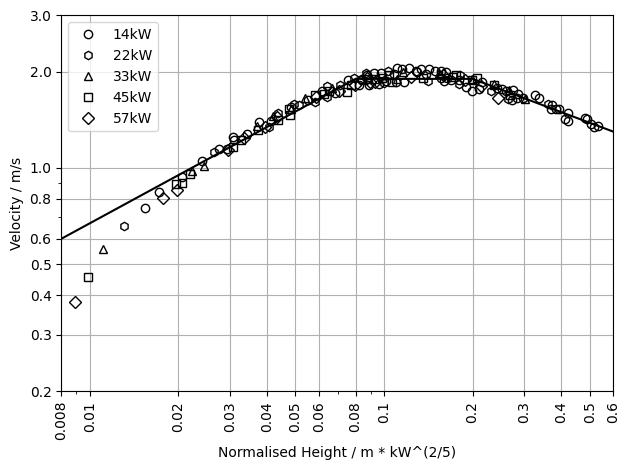

In [21]:
# Plot the velocity experiment data.

# Define ticks and tick labels.
x_ticks = [0.008, 0.01, 0.02,0.03,0.04,0.05,0.06,0.08,0.1,0.2,0.3,0.4,0.5,0.6]
x_ticklabels = ["0.008", "0.01", "0.02","0.03","0.04","0.05","0.06","0.08","0.1","0.2","0.3","0.4","0.5","0.6"]
y_ticks = [0.2,0.3,0.4,0.5,0.6,0.8,1.0,2.0,3.0]
y_ticklabels = ["0.2","0.3","0.4","0.5","0.6","0.8","1.0","2.0","3.0"]


# Set up plotting.
fig, ax = plt.subplots()

# Shortend for convenience.
mcc_exp = plume_sims["McCaffrey"]["Exp"]
mcc_ideal = plume_sims["McCaffrey"]["Ideal"]
# Go over all experiment setups.
for exp_label in list(mcc_exp):
    
    height = mcc_exp[exp_label]["Velocity"]["Height"]
    temp = mcc_exp[exp_label]["Velocity"]["Velocity"]
    plot_marker = mcc_exp[exp_label]["Marker"]
    
    plt.plot(height,
             temp,
             linestyle='None', marker=plot_marker,
             fillstyle='none', color='k',
             label=exp_label)
    
    
plt.plot(mcc_ideal["Velocity"]["Height"], 
         mcc_ideal["Velocity"]["Velocity"], 
         color='k')


# Plot meta data.
plt.grid()
plt.xlim(0.008, 0.6)
plt.xscale('log')
plt.yscale('log')

plt.xlabel("Normalised Height / m * kW^(2/5)")
plt.ylabel("Velocity / m/s")

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticklabels, rotation = 90, 
                   ha="center")

ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticklabels, ha="right")

plt.legend()
plt.tight_layout()


# # Save image.
# file_label = f"McCaffrey_Experiment_Velo.png"
# plot_path = os.path.join(output_dir, 
#                          file_label)
# plt.savefig(plot_path, dpi=320)

## Read Simulation Response

Let's read the simulation responses. We make use of the [fdsreader](../../tools/03_analysis/02_fdsreader) and store the simulation objects in the data collection dictionary.

In [25]:
# Initialise data collection.
plume_sims["McCaffrey"]["Sim"] = dict()
mcc_sims = plume_sims["McCaffrey"]["Sim"]
mcc_labels = list(plume_sims["McCaffrey"]["Exp"])

# Which sets to read?
resolutions = ["C5"]

# Read data sets.
for resolution in resolutions:
    # Add new dictionary per set.
    mcc_sims[resolution] = dict()
    
    # Go over the experiment labels.
    for mcc_label in mcc_labels:
        # Build path to simulation.
        sim_path = os.path.join(mcc_sim_base_path, 
                                resolution, mcc_label)
        
        # Check if FDS simulation exists.
        out_path = os.path.join(sim_path, "McCaffrey.out")
        if os.path.exists(out_path):
            # Read simulation data.
            fdssim = fdsreader.Simulation(sim_path)
            print(f"- FDS sim. read: {resolution}, {mcc_label}")
        else:
            # Handle exception.
            fdssim = None
            print(f"* None ({resolution}, {mcc_label})")

        # Collect FDS simulation result.
        mcc_sims[resolution][mcc_label] = fdssim
    

# Check result.
plume_sims["McCaffrey"]["Sim"]["C5"]["14kW"]

* None (C5, 14kW)
* None (C5, 22kW)
* None (C5, 33kW)
* None (C5, 45kW)
* None (C5, 57kW)


In [ ]:
plume_sims["McCaffrey"]["Sim"]["C5"]["14kW"]

To make life a bit easier further down the line, the column headers are grouped in lists based on their quantity. Since all simulation setups are essentially the same, except for the ehergy release.

In [ ]:
# Sort the DEVC data series.
headers_temp = list()
headers_tc = list()

# Get DEVC info, for convenience.
devcs = plume_sims["McCaffrey"]["Sim"]["C5"]["14kW"].devices

# Go over all DEVC and get their ID.
for devc in devcs:
    if "Temp_" in devc.id:
        headers_temp.append(devc.id)
    elif "TC_" in devc.id:
        headers_tc.append(devc.id)

# Assess the Simulation Response

Two types of devices are present in the simulation: thermocouples and temperature. We llok at these first. Afterwards we look into information from the slice files.

## Plot Temperature Data

To compare the simulation results we utilise the plot created above. They are already prepared here. Now, for each simulation setup the height of the devices needs to be scaled by the energy release of the burner.

First, lets plot a single data series, the "14kW" case of the "C5" resolution. Note, the parameters are provided as variables, such that they can easily be transformed into a loop in a further step.

In [ ]:
# Plot the temperature data.

# Define ticks and tick labels.
x_ticks = [0.008, 0.01, 0.02,0.03,0.04,0.05,0.06,0.08,0.1,0.2,0.3,0.4,0.5,0.6]
x_ticklabels = ["0.008", "0.01", "0.02","0.03","0.04","0.05","0.06","0.08","0.1","0.2","0.3","0.4","0.5","0.6"]
y_ticks = [40,50,60,80,100,200,300,400,500,600,700,800,900]
y_ticklabels = ["40","50","60","80","100","200","300","400","500","600","700","800","900"]


# Set up plotting.
fig, ax = plt.subplots()

# Experiment
# ---------------
# Shortend for convenience.
mcc_exp = plume_sims["McCaffrey"]["Exp"]
mcc_ideal = plume_sims["McCaffrey"]["Ideal"]
# Go over all experiment setups.
for exp_label in list(mcc_exp):
    
    height = mcc_exp[exp_label]["Temperature"]["Height"]
    temp = mcc_exp[exp_label]["Temperature"]["Temperature"]
    plot_marker = mcc_exp[exp_label]["Marker"]
    
    plt.plot(height,
             temp,
             linestyle='None', marker=plot_marker,
             fillstyle='none', color='k',
             label=exp_label)
    
    
plt.plot(mcc_ideal["Temperature"]["Height"], 
         mcc_ideal["Temperature"]["Temperature"], 
         color='k')


# Simulation
# ---------------

# 
resolution = "C5"
mcc_label = "14kW"
hrr = mcc_exp[mcc_label]["Burner"]
plot_marker = mcc_exp[mcc_label]["Marker"]

# Determine normalised heights.
norm_height = np.linspace(0.03,6.57,110) / (hrr**(2/5))

# Shortend for convenience.
mcc_sim_data = plume_sims["McCaffrey"]["Sim"][resolution][mcc_label]
norm_height = np.linspace(0.03,6.57,110) / (hrr**(2/5))
devcs = mcc_sim_data.devices
for header_id, header in enumerate(headers_temp):
    new_y = np.average(devcs[header].data[-35:])
    plt.plot(norm_height[header_id],
             new_y, color='r', fillstyle='none',
             marker=plot_marker)

# 
resolution = "C5"
mcc_label = "57kW"
hrr = mcc_exp[mcc_label]["Burner"]
plot_marker = mcc_exp[mcc_label]["Marker"]

# Determine normalised heights.
norm_height = np.linspace(0.03,6.57,110) / (hrr**(2/5))

# Shortend for convenience.
mcc_sim_data = plume_sims["McCaffrey"]["Sim"][resolution][mcc_label]
norm_height = np.linspace(0.03,6.57,110) / (hrr**(2/5))
devcs = mcc_sim_data.devices
for header_id, header in enumerate(headers_temp):
    new_y = np.average(devcs[header].data[-35:])
    plt.plot(norm_height[header_id],
             new_y, color='r', fillstyle='none',
             marker=plot_marker)



# Plot meta data.
plt.grid()
plt.xlim(0.008, 0.6)
plt.xscale('log')
plt.yscale('log')

plt.xlabel("Normalised Height / m * kW^(2/5)")
plt.ylabel("Temperature / °C")

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticklabels, rotation = 90, 
                   ha="center")

ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticklabels, ha="right")

plt.legend()
plt.tight_layout()


# # Save image.
# file_label = f"McCaffrey_Temp.png"
# plot_path = os.path.join(output_dir, 
#                          file_label)
# plt.savefig(plot_path, dpi=320)

Let's create a loop, since it is now working for a single data series. We can easily built on the variables set up earlier. 

In [ ]:
# Plot the temperature data.

# Define ticks and tick labels.
x_ticks = [0.008, 0.01, 0.02,0.03,0.04,0.05,0.06,0.08,0.1,0.2,0.3,0.4,0.5,0.6]
x_ticklabels = ["0.008", "0.01", "0.02","0.03","0.04","0.05","0.06","0.08","0.1","0.2","0.3","0.4","0.5","0.6"]
y_ticks = [40,50,60,80,100,200,300,400,500,600,700,800,900]
y_ticklabels = ["40","50","60","80","100","200","300","400","500","600","700","800","900"]


# Set up plotting.
fig, ax = plt.subplots()

# Experiment
# ---------------
# Shortend for convenience.
mcc_exp = plume_sims["McCaffrey"]["Exp"]
mcc_ideal = plume_sims["McCaffrey"]["Ideal"]
# Go over all experiment setups.
for exp_label in list(mcc_exp):
    
    height = mcc_exp[exp_label]["Temperature"]["Height"]
    temp = mcc_exp[exp_label]["Temperature"]["Temperature"]
    plot_marker = mcc_exp[exp_label]["Marker"]
    
    plt.plot(height,
             temp,
             linestyle='None', marker=plot_marker,
             fillstyle='none', color='k',
             label=exp_label)
    
    
plt.plot(mcc_ideal["Temperature"]["Height"], 
         mcc_ideal["Temperature"]["Temperature"], 
         color='k')


# Simulation
# ---------------

for exp_label in list(mcc_exp):
    resolution = "C5"
#     exp_label = "14kW"
    hrr = mcc_exp[exp_label]["Burner"]
    plot_marker = mcc_exp[exp_label]["Marker"]

    # Determine normalised heights.
    norm_height = np.linspace(0.03,6.57,110) / (hrr**(2/5))

    # Shortend for convenience.
    mcc_sim_data = plume_sims["McCaffrey"]["Sim"][resolution][exp_label]
    
    # Get DEVC data.
    devcs = mcc_sim_data.devices
    for header_id, header in enumerate(headers_temp):
        new_y = np.average(devcs[header].data[-35:])
        plt.plot(norm_height[header_id],
                 new_y, color='r', fillstyle='none',
                 marker=plot_marker)


# Plot meta data.
plt.grid()
plt.xlim(0.008, 0.6)
plt.xscale('log')
plt.yscale('log')

plt.xlabel("Normalised Height / m * kW^(2/5)")
plt.ylabel("Temperature / °C")

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticklabels, rotation = 90, 
                   ha="center")

ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticklabels, ha="right")

plt.legend()
plt.tight_layout()


# # Save image.
# file_label = f"McCaffrey_Temp.png"
# plot_path = os.path.join(output_dir, 
#                          file_label)
# plt.savefig(plot_path, dpi=320)

## SLCF

Next we take a look at the `SLCF` data. The simulations contain vertical slices at a single location and multiple horizontal at different heights above the burner. Quantities provided are `TEMPAERTURE`, `DENSITY` and velocities by component, for example `W-VELOCITY`. Given this information, how could the mass flow be determined?

First lets have a look at the content of fdsreader simulation object, with respect to the slices.

In [ ]:
resolution = "C5"
mcc_label = "57kW"
mcc_sim_data = plume_sims["McCaffrey"]["Sim"][resolution][mcc_label]

# Check content.
mcc_sim_data.slices[:3]

We can pick a horizontal slice and a time step. Again think about setting up variables for easier access later on.

In [ ]:
# Choose parameters to get desired slice and time step.
resolution = "C5"
mcc_label = "57kW"
n_slcf = 2
sim_time = 30  # s


# Finally, also the extend is specified to move from index to physical space.
mcc_slcf_data = plume_sims["McCaffrey"]["Sim"][resolution][mcc_label].slices
time_step = mcc_slcf_data[n_slcf].get_nearest_timestep(sim_time)
sim_time_actual = mcc_slcf_data[0].times[time_step]
# 
print(f"Time step: {time_step}")
print(f"Simulation time: {sim_time_actual}")


# Plot the slice information as image.
plt.imshow(mcc_slcf_data[n_slcf][0].data[time_step].T, 
           origin='lower',
           vmax=400,
           extent=mcc_slcf_data[n_slcf].extent.as_list())


# Plot meta data.
plt.colorbar(label='Temperature / °C')
plt.xlabel('x coordinate / m')
plt.ylabel('z coordinate / m')

plt.tight_layout()

It might be useful to limit the area of slice to an area closer around the plume. For this we can set up some frame. First the number of cells is extracted. We know from the setup the number of cells is uneven and also there is an equal amount of cells in x and y directions. Thus we define the frame from a single number, here labelled `cut_start`, and use it to compute `cut_end`. 

In [ ]:
# Choose parameters to get desired slice and time step.
resolution = "C5"
mcc_label = "57kW"
n_slcf = 2
sim_time = 30  # s

# Define window to cut SLCF data.
cut_start_x = 10

cut_end_x = (45 - cut_start_x)
print(cut_start_x, cut_end_x, cut_end_x - cut_start_x)

# Finally, also the extend is specified to move from index to physical space.
mcc_slcf_data = plume_sims["McCaffrey"]["Sim"][resolution][mcc_label].slices
time_step = mcc_slcf_data[n_slcf].get_nearest_timestep(sim_time)
sim_time_actual = mcc_slcf_data[0].times[time_step]
# 
print(f"Time step: {time_step}")
print(f"Simulation time: {sim_time_actual}")

plt.imshow(mcc_slcf_data[n_slcf][0].data[time_step,
                                         cut_start_x:cut_end_x,
                                         cut_start_x:cut_end_x], 
           origin='lower',
           vmax=400,
           extent=mcc_slcf_data[n_slcf].extent.as_list())


# Plot meta data.
plt.colorbar(label='Temperature / °C')
plt.xlabel('x coordinate / m')
plt.ylabel('z coordinate / m')

plt.tight_layout()

In the McCaffrey experiments the recorded data was averaged over time. We can make use of `np.average()` to average the over a couple of frames for each cell.

In [ ]:
n_slcf = 4
cut_start_x = 10
n_frames = -30

n_x_cells = sim.slices[n_slcf][0].data[-1:, 0].size
cut_end_x = (45 - cut_start_x)
print(cut_start_x, cut_end_x, cut_end_x - cut_start_x)

plt.imshow(np.average(sim.slices[n_slcf][0].data[n_frames:,
                                                 cut_start_x:cut_end_x,
                                                 cut_start_x:cut_end_x], axis=0).T, 
           origin='lower',
           vmax=200,
           extent=sim.slices[0].extent.as_list())

With setting an unequal window, we can extract rows  of cells and plot their data. Use this functionality to determine the averaged temperature and velocity profiles at different heights across the plume centre. 

In [ ]:
# n_slcf = 5
# cut_start_x = 15
n_frames = -35

cut_end_x = (45 - cut_start_x)
print(cut_start_x, cut_end_x, cut_end_x - cut_start_x)

cut_start_y = 22
cut_end_y = (45 - cut_start_y)
print(cut_start_y, cut_end_y, cut_end_y - cut_start_y)

cross_section = np.average(sim.slices[slcf_id+16][0].data[n_frames:,
                                                 cut_start_x:cut_end_x,
                                                 cut_start_y:cut_end_y], axis=0)


plt.plot(cross_section)